In [1]:
%matplotlib inline
import utils
import torch
import matplotlib.pyplot as plt
import numpy as np

input_images, target_masks = utils.load_data(max_area=120000)

target_masks = utils.make_agregated_masks(target_masks)

for x in [input_images, target_masks]:
    print(x.shape)
    print(x.min(), x.max())

100%|█████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 366.39it/s]


(81, 336, 512)
0 255
(81, 336, 512)
0.0 1.0


In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from sklearn.model_selection import train_test_split

class MakeDataset(Dataset):
    def __init__(self, input_images, target_masks, transform=None):
        self.input_images, self.target_masks = input_images, target_masks        
        self.transform = transform
    
    def __len__(self):
        return len(self.input_images)
    
    def __getitem__(self, idx):        
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return [image, mask]

# use same transform for train/val for this example
trans = transforms.Compose([transforms.ToTensor(),])

images_train, images_test, masks_train, masks_test = train_test_split(input_images, target_masks, test_size=18)

train_set = MakeDataset(images_train, masks_train, transform = trans)
val_set = MakeDataset(images_test, masks_test, transform = trans)


batch_size = 12

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

torch.Size([12, 1, 336, 512]) torch.Size([12, 1, 336, 512])


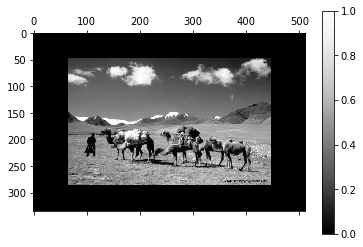

In [3]:
# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))
print(inputs.shape, masks.shape)
plt.matshow(inputs[0,0], cmap='Greys_r')
plt.colorbar()

In [4]:
from UNet import UNet
from torchsummary import summary

device = torch.device("cpu")

model = UNet(in_channels=1, out_channels=1)
model = model.to(device)

summary(model, input_size=(1, 272, 416), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              ReLU-1          [-1, 1, 272, 416]               0
            Conv2d-2         [-1, 32, 272, 416]             320
            Conv2d-3         [-1, 32, 136, 208]           9,248
              ReLU-4         [-1, 32, 136, 208]               0
            Conv2d-5         [-1, 64, 136, 208]          18,496
            Conv2d-6          [-1, 64, 68, 104]          36,928
              ReLU-7          [-1, 64, 68, 104]               0
            Conv2d-8         [-1, 128, 68, 104]          73,856
            Conv2d-9          [-1, 128, 34, 52]         147,584
             ReLU-10          [-1, 128, 34, 52]               0
           Conv2d-11          [-1, 256, 34, 52]         295,168
         Upsample-12         [-1, 256, 68, 104]               0
           Conv2d-13         [-1, 128, 68, 104]         442,496
             ReLU-14         [-1, 128, 

In [5]:
from collections import defaultdict
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

def train_model(model, optimizer, scheduler, num_epochs=25, device=torch.device('cuda')):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 30)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            epoch_samples = 0
            
            for inputs, masks in dataloaders[phase]:
                inputs = inputs.to(device, dtype=torch.float)
                masks = masks.to(device, dtype=torch.float)             
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = utils.loss(outputs, masks)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        

            print(f'{phase} loss: {loss}')
            epoch_loss = loss
            if phase == 'train':
                scheduler.step()
            
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print(f'{time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {best_loss:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
# Observe that all parameters are being optimized
torch.cuda.empty_cache()
device = torch.device('cuda')

model = UNet(in_channels=1, out_channels=1)
model.load_state_dict(torch.load("weights_to_train.pth"))
model = model.to(device)

In [ ]:
optimizer_ft = optim.Adam(model.parameters(), lr=1e-5)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=1000, gamma=0.1)
torch.autograd.set_detect_anomaly(True)
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=2500)

Epoch 1/2500
------------------------------
LR 1e-05
train loss: 0.6855003833770752
val loss: 0.6258004903793335
saving best model
0m 6s
Epoch 2/2500
------------------------------
LR 1e-05
train loss: 0.6542771458625793
val loss: 0.6018775701522827
saving best model
0m 4s
Epoch 3/2500
------------------------------
LR 1e-05
train loss: 0.6138150691986084
val loss: 0.6298547983169556
0m 4s
Epoch 4/2500
------------------------------
LR 1e-05
train loss: 0.6965595483779907
val loss: 0.6044037342071533
0m 4s
Epoch 5/2500
------------------------------
LR 1e-05
train loss: 0.7013313174247742
val loss: 0.6033006906509399
0m 4s
Epoch 6/2500
------------------------------
LR 1e-05
train loss: 0.6872864365577698
val loss: 0.6534522771835327
0m 4s
Epoch 7/2500
------------------------------
LR 1e-05
train loss: 0.695396900177002
val loss: 0.6622632741928101
0m 4s
Epoch 8/2500
------------------------------
LR 1e-05
train loss: 0.6454139351844788
val loss: 0.5643360018730164
saving best model
0

val loss: 0.6106245517730713
0m 4s
Epoch 69/2500
------------------------------
LR 1e-05
train loss: 0.6406474113464355
val loss: 0.640311598777771
0m 4s
Epoch 70/2500
------------------------------
LR 1e-05
train loss: 0.5747647881507874
val loss: 0.6282620429992676
0m 4s
Epoch 71/2500
------------------------------
LR 1e-05
train loss: 0.5850227475166321
val loss: 0.6876324415206909
0m 4s
Epoch 72/2500
------------------------------
LR 1e-05
train loss: 0.5910751819610596
val loss: 0.6298648715019226
0m 4s
Epoch 73/2500
------------------------------
LR 1e-05
train loss: 0.71224045753479
val loss: 0.647108793258667
0m 4s
Epoch 74/2500
------------------------------
LR 1e-05
train loss: 0.630728006362915
val loss: 0.6377401351928711
0m 4s
Epoch 75/2500
------------------------------
LR 1e-05
train loss: 0.7072758674621582
val loss: 0.6204596757888794
0m 4s
Epoch 76/2500
------------------------------
LR 1e-05
train loss: 0.6309683918952942
val loss: 0.5763452053070068
0m 4s
Epoch 77/2

train loss: 0.6464437246322632
val loss: 0.639963686466217
0m 4s
Epoch 138/2500
------------------------------
LR 1e-05
train loss: 0.5195387601852417
val loss: 0.5795037746429443
0m 4s
Epoch 139/2500
------------------------------
LR 1e-05
train loss: 0.6161719560623169
val loss: 0.6330958008766174
0m 4s
Epoch 140/2500
------------------------------
LR 1e-05
train loss: 0.6192611455917358
val loss: 0.659061074256897
0m 4s
Epoch 141/2500
------------------------------
LR 1e-05
train loss: 0.5409205555915833
val loss: 0.5760688781738281
0m 4s
Epoch 142/2500
------------------------------
LR 1e-05
train loss: 0.7231369018554688
val loss: 0.600997805595398
0m 4s
Epoch 143/2500
------------------------------
LR 1e-05
train loss: 0.5294275879859924
val loss: 0.6487554311752319
0m 4s
Epoch 144/2500
------------------------------
LR 1e-05
train loss: 0.7326981425285339
val loss: 0.6950703859329224
0m 4s
Epoch 145/2500
------------------------------
LR 1e-05
train loss: 0.733928918838501
val l

In [ ]:
torch.save(model.state_dict(), "weights_to_train.pth")

# Observation des résultats

In [ ]:
from UNet import UNet
from torchsummary import summary


device = torch.device('cuda')
model = UNet(in_channels=1, out_channels=1)
model.load_state_dict(torch.load("weights_to_train.pth"))
model = model.to(device=device)

In [ ]:
inputs, masks = next(iter(dataloaders['val']))
inputs = inputs.to(device,  dtype=torch.float)
outputs = model(inputs)

In [ ]:
plt.matshow(inputs[2, 0].cpu(), cmap='Greys_r')
plt.colorbar()

In [ ]:
print(outputs.max(), outputs.min())
plt.matshow(outputs[2, 0].cpu().detach().numpy(), cmap='Greys')
plt.colorbar()

In [ ]:
fig = plt.figure()
for i in range(batch_size):
    plt.matshow(0.3*outputs[i, 0].cpu().detach().numpy() + 0.5*inputs[i, 0].cpu().detach().numpy(), cmap='Greys_r')
    plt.colorbar()
    fig.add_subplot()